In [402]:
from os.path import exists
import pickle
import numpy as np
import requests
import json
# image processing
from skimage import io
import matplotlib.pyplot as plt
import cv2 
# tenserflow imports
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Multiply, Concatenate, Average
from tensorflow.keras.activations import softmax
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.optimizers import Adam

# Parameters
The following parameters allow for adjusting the size of the bag-of-words embedding, as well as other various factors.

In [403]:
g_BAGOFWORDS_SIZE = 2000
g_EMBIMG_SIZE = 1000 # known from the  RESNET50 output

# Create Tokenizers for the Questions and Answers.

Of note, this is a bag-of-words (BoW) model as seen in Agrawal et al. 


This was implimented by hand to allow for flecibility in testing the model.

In [404]:
class QuestionTokenizer:
    """ Question Tokenizer """
    
    def __init__(self, q_string_list, a_string_list, vector_size, percent_q=0.90):
        self.word2index = {}
        self.index2word = {}
        self.vector_size = vector_size
        self.percent_q = percent_q
        self.initialize(q_string_list, a_string_list)
        
    def tokenize(self, string):
        """
        This method will turn a string of words into 
        a bag-of-words vector.
        
        if inherited, use change this.
        """
        token = np.zeros((self.vector_size))
        word_list = string.split(" ")
        index_count = {}
        for word in word_list:
            if word in self.word2index:
                index = self.word2index[word]
                if index in index_count:
                    index_count[index] += 1
                else:
                    index_count[index] = 1
        for index, count in index_count.items():
            token[index] = count / max(index_count.values())
        return token
    
    def initialize(self, q_string_list, a_string_list):
        """ 
        description: creates the underlying datastructure
        input: string list for questions, string list for answers
        output: count dictionary
        """
        # Obtain words only.
        q_word_list = []
        for string in q_string_list:
            q_word_list += string.split(" ")
        a_word_list = []
        for string in a_string_list:
            a_word_list += string.split(" ")
        # obtain top words. 
        # Note: both answers and questions used here due to Agrawal et al. fig 5
        print("finding top words")
        q_word_top = self.__retrieve_top_N(q_word_list, int(self.vector_size * self.percent_q))
        a_word_top = self.__retrieve_top_N(a_word_list, int(self.vector_size * (1-self.percent_q)))
        print("\t DONE!")
        
        # add to mappings.
        print("making mappings")
        self.__make_mappings(q_word_top + a_word_top)
        print("\t DONE!")
    
    def __retrieve_top_N(self, word_list, N):
        """
        description: retrieves the top N words in a count dictionary.
        input: number of words to grab, dictionary of word counts.
        output: list of top N words.
        """
        # get dictionary count
        count_dictionary = self.__count_word_frequency(word_list)
        # return top N
        tuple_map = [(k,v) for k, v in count_dictionary.items()]
        tuple_map.sort(key=lambda a: a[1], reverse=True)
        top_N = [i[0] for i in tuple_map[:N]]
        return top_N
    
    def __count_word_frequency(self, string_list):
        """ 
        description: expects list of strings.
        input: string list
        output: count dictionary
        """
        word_count = {}
        for word in string_list:
            if word == '': continue #skip white space
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
        return word_count
    
    def __make_mappings(self, word_list):
        """
        description: given a word list, this method makes mappings
        input: creates the vector mappings.
        output: None
        """
        for index, word in enumerate(word_list):
            self.word2index[word] = index
            self.index2word[index] = word
            
            
class AnswerTokenizer(QuestionTokenizer):
    """ Tokenizer for the Answers"""
    
    def __init__(self, a_string_list, vector_size, q_string_list=[], percent_q=0.00):
        self.word2index = {}
        self.index2word = {}
        self.vector_size = vector_size
        self.percent_q = percent_q
        self.initialize(q_string_list, a_string_list)
        
    def tokenize(self, string):
        """
        This method will turn a string of words into 
        a TOKENIZED (not bag of words) vector.
        
        if inherited, use change this.
        """
        token = np.zeros((self.vector_size))
        word_list = string.split(" ")
        index_count = {}
        for word in word_list:
            if word in self.word2index:
                index = self.word2index[word]
                if index in index_count:
                    index_count[index] += 1
                else:
                    index_count[index] = 1
        for index, count in index_count.items():
            token[index] = 1
        return token

In [405]:
test_q = ["who are you", "who am I", "how are you"]
test_a = ["no", "yes", "yes "]

# make tokenizer
q_tokenizer = QuestionTokenizer(test_q, test_a, 4)
print(q_tokenizer.word2index)

# test tokenization
q_tokenizer.tokenize('yes')
q_tokenizer.tokenize('who you')
assert all(q_tokenizer.tokenize('you') == [0., 0., 1., 0.])


# test answer tokenization
a_tokenizer = AnswerTokenizer(test_a, 2)
assert all(a_tokenizer.tokenize('yes no no') == [1, 1])

finding top words
	 DONE!
making mappings
	 DONE!
{'who': 0, 'are': 1, 'you': 2}
finding top words
	 DONE!
making mappings
	 DONE!


# In-House Methods

1. process_data() - this method preprocesses the input data url, returning vectors ready for the downstream NN.
    2. data2rawlists() - this method, used by process_data(), parses the json URL and turns data into lists.
    3. process_image_urls() - this method, used by process_data(), converts the image urls into embedded vectors using an input model. Default model is the ResNet50.
        4. imageurl2embedding() - uses model to convert image URL.
        5. transform_image() - gets image into correct shape for ResNet (easier to train than VGG)
    6. process_q_or_a() - process a list of questions or answers using an in-house tokenizer than creates a bag of words model similair to the described implimentation by Agrawal et al. 

In [406]:
def process_data(data_url, count, q_tokenizer, a_tokenizer):
    """
    MAJOR PREPROCESS METHOD.
    
    This processes a train, validate, or test annotation file
    and saves the results as a local pickle object. 
    
    This allows for caching, so embeddings only have to be made once per size.
    """
    # type
    data_type = data_url.split("/")[-1].replace(".json", "")
    # turn json info into lists.
    print("Processing json \n")
    raw_imgurl_list, raw_questions_list, raw_answers_list = data2rawlists(data_url, count)
    print("\t DONE \n\n")
    
    # process questions and answers.
    print("Making Tokenizers \n")
    ## use Q Tokenizers
    processed_qs = process_q_or_a(raw_questions_list, q_tokenizer)
    ## use A Tokenizers
    processed_as = process_q_or_a(raw_answers_list, a_tokenizer)    
    answer_count = len(a_tokenizer.word2index.keys())
    print("\t DONE \n\n")
    
    # process images
    print("Making Images \n")
    image_emb_file = f"{data_type}_{count}_images.pickle"
    if exists(image_emb_file):
        image_embeddings = pickle.load(open(image_emb_file, "rb" ))
    else:
        image_embeddings = process_image_urls(raw_imgurl_list)
        pickle.dump(image_embeddings, open(image_emb_file, "wb" ))
    print("\t DONE \n\n")
    
    return np.array(image_embeddings), np.array(processed_qs), np.array(processed_as), answer_count

In [407]:
# Process a data set and return raw lists.
def data2rawlists(data, N, img_dir="https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"):
    """ returns list of all data into lists """
    raw_imgurl_list, raw_questions_list, raw_answers_list = [], [], []
    split_val_data = requests.get(data, allow_redirects=True)
    data = split_val_data.json()
    for index in range(N):
        #index data
        vq = data[index]
        # get/store image URL
        image_name = vq['image']
        image_url = img_dir + image_name
        raw_imgurl_list.append(image_url)
        # get/store Q string
        question = vq['question']
        raw_questions_list.append(question)
        # get/store answers
        if 'answers' in vq:
            answers = vq['answers']
            label = answers[0]['answer']
            raw_answers_list.append(label)
    return raw_imgurl_list, raw_questions_list, raw_answers_list 

# example usage
# raw_imgurl_list, raw_questions_list, raw_answers_list = data2rawlists(data, 20000)

In [408]:
resnet_model = resnet50.ResNet50()

def process_image_urls(img_list):
    """
    processes list of images into list of embeddings
    """
    img_emb = []
    for count, img in enumerate(img_list):
        img_emb.append(imageurl2embedding(img)[0])
        if count % 10 == 0:
            print(f"working on #: {count}")
    return img_emb

def imageurl2embedding(unprocess_img_url, model=resnet_model):
    """
    uses model to make embedding
    """
    x = transform_image(unprocess_img_url)
    embedding = model.predict(x)
    return embedding

def transform_image(unprocess_img_url, new_shape=(224, 224)):
    """
    gets image into correct shape for ResNet (easier to train than VGG)
    """
    img = io.imread(unprocess_img_url)
#     visualize_image(unprocess_img_url)
    x = cv2.resize(img, new_shape)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    return x

In [409]:
def process_q_or_a(q_a_list, tokenizer):
    """
    processes list of questions or answers.
    """
    string_emb_list = []
    for count, string in enumerate(q_a_list):
        string_emb_list.append(tokenizer.tokenize(string))
        if count % 1000 == 0:
            print(f"working on #: {count}")
    return string_emb_list

# Preprocessing Steps

Depending on whether or not it has been ran for the images, this step may be slow or fast. It's suggested to run with a low amount first to see how it works. 

In [410]:
# Preprocess Training Data
data_url = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/train.json"

number_of_training = 10000
# training data used to create tokenizer
raw_imgurl_list, raw_questions_list, raw_answers_list = data2rawlists(data_url, number_of_training)
q_tokenizer = QuestionTokenizer(raw_questions_list, raw_answers_list, g_BAGOFWORDS_SIZE)
a_tokenizer = AnswerTokenizer(raw_answers_list, len(raw_answers_list))

train_processed_img, train_processed_q, train_processed_a, train_answers_count = process_data(data_url, number_of_training, q_tokenizer, a_tokenizer)

finding top words
	 DONE!
making mappings
	 DONE!
finding top words
	 DONE!
making mappings
	 DONE!
Processing json 

	 DONE 


Making Tokenizers 

working on #: 0
working on #: 1000
working on #: 2000
working on #: 3000
working on #: 4000
working on #: 5000
working on #: 6000
working on #: 7000
working on #: 8000
working on #: 9000
working on #: 0
working on #: 1000
working on #: 2000
working on #: 3000
working on #: 4000
working on #: 5000
working on #: 6000
working on #: 7000
working on #: 8000
working on #: 9000
	 DONE 


Making Images 

	 DONE 




In [411]:
print(train_processed_img.shape)
print(train_processed_q.shape)
print(train_processed_a.shape)

(10000, 1000)
(10000, 2000)
(10000, 10000)


In [412]:
# Preprocess validation Data
data_url = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/val.json"
val_processed_img, val_processed_q, val_processed_a, val_answers_count = process_data(data_url, 2000, q_tokenizer, a_tokenizer)

Processing json 

	 DONE 


Making Tokenizers 

working on #: 0
working on #: 1000
working on #: 0
working on #: 1000
	 DONE 


Making Images 

	 DONE 




In [413]:
print(val_processed_img.shape)
print(val_processed_q.shape)
print(val_processed_a.shape)

(2000, 1000)
(2000, 2000)
(2000, 10000)


In [414]:
# Preprocess Testing Data
data_url = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/test.json"
test_processed_img, test_processed_q, test_processed_a, test_answers_count = process_data(data_url, 1000, q_tokenizer, a_tokenizer)

Processing json 

	 DONE 


Making Tokenizers 

working on #: 0
	 DONE 


Making Images 

	 DONE 




# Create Models.

Here 3 different VQA models are created. Note that the Image Channel has beem processed by this point using a "frozen" copy of ResNet50, and the questions are really just a bag-of-words model. 

In [352]:
from tensorflow.keras.layers import Dense, Multiply, Concatenate, Average
from tensorflow.keras.activations import softmax
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.optimizers import Adam

In [434]:
# MODEL 1

# get input ready
img_in_layer = Input(shape=(g_EMBIMG_SIZE,))
bow_in_layer = Input(shape=(g_BAGOFWORDS_SIZE,))
# send through FF
EMBEDDING_SIZE = 1000
img_in_emb_layer = Dense(EMBEDDING_SIZE, activation="tanh")(img_in_layer)
bow_in_emb_layer = Dense(EMBEDDING_SIZE, activation="tanh")(bow_in_layer)
# combine output from first FFs
mix_layer = Multiply()([img_in_emb_layer, bow_in_emb_layer ])
# FF on combined information
linear_layer = Dense(1000, activation="tanh")(mix_layer)
out_layer = Dense(train_processed_a.shape[1], activation=softmax)(linear_layer)


# create model
model_1 = Model(inputs=[img_in_layer, bow_in_layer], outputs=out_layer)

model_1.summary()

Model: "model_58"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_134 (InputLayer)         [(None, 1000)]       0           []                               
                                                                                                  
 input_135 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 dense_224 (Dense)              (None, 1000)         1001000     ['input_134[0][0]']              
                                                                                                  
 dense_225 (Dense)              (None, 1000)         2001000     ['input_135[0][0]']              
                                                                                           

In [435]:
# MODEL 2

# get input ready
img_in_layer = Input(shape=(g_EMBIMG_SIZE,))
bow_in_layer = Input(shape=(g_BAGOFWORDS_SIZE,))
# send through FF
img_in_emb_layer = Dense(EMBEDDING_SIZE, activation="tanh")(img_in_layer)
bow_in_emb_layer = Dense(EMBEDDING_SIZE, activation="tanh")(bow_in_layer)
# combine output from first FFs
mix_layer = Concatenate(axis=1)([img_in_emb_layer, bow_in_emb_layer ])
# FF on combined information
linear_layer = Dense(1000, activation="tanh")(mix_layer)
out_layer = Dense(train_processed_a.shape[1], activation=softmax)(linear_layer)

# create model
model_2 = Model(inputs=[img_in_layer, bow_in_layer], outputs=out_layer)

model_2.summary()

Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_136 (InputLayer)         [(None, 1000)]       0           []                               
                                                                                                  
 input_137 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 dense_228 (Dense)              (None, 1000)         1001000     ['input_136[0][0]']              
                                                                                                  
 dense_229 (Dense)              (None, 1000)         2001000     ['input_137[0][0]']              
                                                                                           

In [436]:
# MODEL 3

# get input ready
img_in_layer = Input(shape=(g_EMBIMG_SIZE,))
bow_in_layer = Input(shape=(g_BAGOFWORDS_SIZE,))
# send through FF
img_in_emb_layer = Dense(EMBEDDING_SIZE, activation="tanh")(img_in_layer)
bow_in_emb_layer = Dense(EMBEDDING_SIZE, activation="tanh")(bow_in_layer)
# combine output from first FFs
mix_layer = Average()([img_in_emb_layer, bow_in_emb_layer ])
# FF on combined information
linear_layer = Dense(1000, activation="tanh")(mix_layer)
out_layer = Dense(train_processed_a.shape[1], activation=softmax)(linear_layer)


# create model
model_3 = Model(inputs=[img_in_layer, bow_in_layer], outputs=out_layer)
model_3.summary()

Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_138 (InputLayer)         [(None, 1000)]       0           []                               
                                                                                                  
 input_139 (InputLayer)         [(None, 2000)]       0           []                               
                                                                                                  
 dense_232 (Dense)              (None, 1000)         1001000     ['input_138[0][0]']              
                                                                                                  
 dense_233 (Dense)              (None, 1000)         2001000     ['input_139[0][0]']              
                                                                                           

# Train and Save Models
While training, the loss information is saved.

Epoch 1/40
3/3 [==============================] - 8s 2s/step - loss: 15.2158 - accuracy: 0.0825 - val_loss: 15.1737 - val_accuracy: 0.2215
Epoch 2/40
3/3 [==============================] - 5s 2s/step - loss: 15.1954 - accuracy: 0.1405 - val_loss: 15.1363 - val_accuracy: 0.2210
Epoch 3/40
3/3 [==============================] - 5s 1s/step - loss: 15.1550 - accuracy: 0.1405 - val_loss: 15.0666 - val_accuracy: 0.2210
Epoch 4/40
3/3 [==============================] - 7s 3s/step - loss: 15.0793 - accuracy: 0.1405 - val_loss: 14.9378 - val_accuracy: 0.2210
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 14.9378 - accuracy: 0.1405 - val_loss: 14.6957 - val_accuracy: 0.2210
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 14.6703 - accuracy: 0.1405 - val_loss: 14.2443 - val_accuracy: 0.2210
Epoch 7/40
3/3 [==============================] - 5s 2s/step - loss: 14.1865 - accuracy: 0.1405 - val_loss: 13.4603 - val_accuracy: 0.2210
Epoch 8/40
3/3 [===========

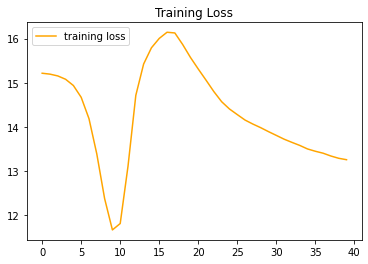

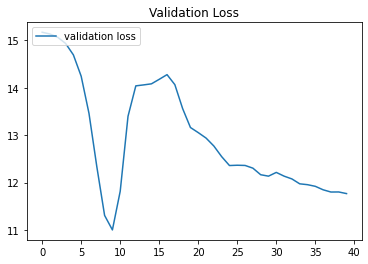

In [437]:
opt = Adam(learning_rate=0.001, decay=1e-3 / 200)
EPOCHS = 40
for model in [model_1]:#, model_2, model_3]:
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(x=[train_processed_img, train_processed_q], y=train_processed_a, 
                validation_data=([val_processed_img, val_processed_q], val_processed_a),
                epochs=EPOCHS, batch_size=4000)
    
    # create plot illustrating the training history
    plt.title(f"Training Loss")
    plt.plot(model.history.history['loss'], label='training loss', color='orange')
    plt.legend(loc="upper left")
    plt.show()
    plt.title(f"Validation Loss")
    plt.plot(model.history.history['val_loss'], label='validation loss')
    plt.legend(loc="upper left")
    plt.show()

# obtain accuracy on the validation data

Here the metric is based on the crowd agreement, per se.

In [428]:
def score(prediction_list, true_raw, answer_tokenizer=a_tokenizer):
    """
    This method scores the output prediction
    against the true raw answers
    """
    accuracy_array = []
    # loop through prediction, detokenize
    for index, pred in enumerate(prediction_list):
        word = answer_tokenizer.index2word[np.argmax(pred)]
        true_list = true_raw[index]
#         print(word, true_list)
        accuracy_array.append(np.minimum(1.0, true_list.count(word)/3.0))
    return accuracy_array

def get_predictions(prediction_list, answer_tokenizer=a_tokenizer):
    """
    returns predicted words
    """
    predicted_words = []
    # loop through prediction, detokenize
    for index, pred in enumerate(prediction_list):
        word = answer_tokenizer.index2word[np.argmax(pred)]
        predicted_words.append(word)
    return predicted_words

def url2truelist(data):
    """
    This method obtains a list of lists portraying 
    the characterized image labels.
    """
    answers = []
    for x in data:
        tmp = []
        for y in x['answers']:
            tmp.append(y['answer'])
        answers.append(tmp)
    return answers

In [429]:
data_url = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/val.json"
split_val_data = requests.get(data_url, allow_redirects=True)
data = split_val_data.json()
true_list = url2truelist(data)

In [430]:

for model in [model_1, model_2, model_3]:
    prediction_list = model.predict([np.array(val_processed_img), np.array(val_processed_q)])
    score_array = np.average(score(prediction_list, true_list))
    print(score_array)

0.2306666666666667
0.42966666666666664
0.42266666666666663


# Make predictions for first 1000 samples of testing

In [433]:
model = model_1 # best model
prediction_list = model.predict([np.array(test_processed_img), np.array(test_processed_q)])
prediction_list = get_predictions(prediction_list)
df = pd.DataFrame(prediction_list)
df.to_csv("results.csv", header = None, index = None)